# RNA Structure Prediction Through Reinforcement Learning

This notebook shows how to train and evaluate a simple model with reinforcement
learning.


## Requirements to Execute this Notebook

- A Python virtual environment installed as described in the `readme.rst` file
  of the project.


## Presentation

Reinforcement learning (RL) is a machine learning approach that consists in
training an *agent* to perform the right *actions* against an *environment* to
accomplish some task.


### Why Not Use Deep Learning Instead?

RL imposes physical constraints more effectively than DL.

Neural networks produce a matrix whose elements range between 0 and 1 that can
be interpreted as pseudo energies terms. This output has to be converted to a
contact matrix by applying hard constraints.

Some models, like ATTFold, apply hard constraint by multiplying the contact
matrix with a mask that represents physically possible pairings with 1 and other
pairings with 0. This approach improves the predictions by eliminating some
false positives, but not all of them. In most cases, the masked prediction has
to be further processed to obtain the prediction. This can be done with
non-learning methods (i.e. applying rules) or training an algorithm to do it.


### Application to RNA Structure Prediction

In the context of RNA secondary structure prediction, a
RL model can use the following components:

- The **agent** is a function that predicts the structure.
- The **actions** performed by the agent consist in (1) adding an element to the
  contact matrix, (2) removing an element from the contact matrix, and (3)
  displacing an element in the contact matrix.
- The **environment** is a contact matrix.
- The **reward** is a function that compares the predicted structure against the
  real structure.


## Model


### Required Imports

In [1]:
from random import randint

from torch import nn, optim, stack, squeeze, tensor
import torch.nn.functional as F

from diurnal import train, structure, visualize, evaluate
import diurnal.models
from diurnal.utils import synthetic

### Prepare Input Data

This section creates synthetic data. Refer to the notebook
`synthetic_pipeline.ipynb` for a detailed presentation of the process.

In [2]:
# Create data.
N = 2000  # Number of structures. May contain duplicates.
n_min = 10  # Minimum length of a synthetic structure.
n_max = 32  # Maximum length of a synthetic structure.

primary = []
secondary = []

for _ in range(N):
    p, s = synthetic.make_structures(randint(n_min, n_max))
    primary.append(p)
    secondary.append(s)

train_x, validation_x, test_x = train.split(primary, (0.8, 0.1, 0.1))
train_y, validation_y, test_y = train.split(secondary, (0.8, 0.1, 0.1))

In [3]:
# Format data.
SIZE = 32  # Normalized input size.
SCHEME = structure.Schemes.IUPAC_PAIRINGS_SCALARS  # Primary structure encoding.
primary_formatter = lambda X: [
    structure.to_half_matrix(
        structure.Primary.to_matrix(x, SIZE, SCHEME)
    ) for x in X
]

train_x = primary_formatter(train_x)
validation_x = primary_formatter(validation_x)
test_x = primary_formatter(test_x)

POWER = 5  # Parameter to elaborate the distance matrix.
secondary_formatter = lambda Y: [
    structure.to_half_matrix(
        structure.Secondary.to_distance_matrix(y, SIZE, power = POWER)
    ) for y in Y
]
train_y = secondary_formatter(train_y)
validation_y = secondary_formatter(validation_y)
test_y = secondary_formatter(test_y)

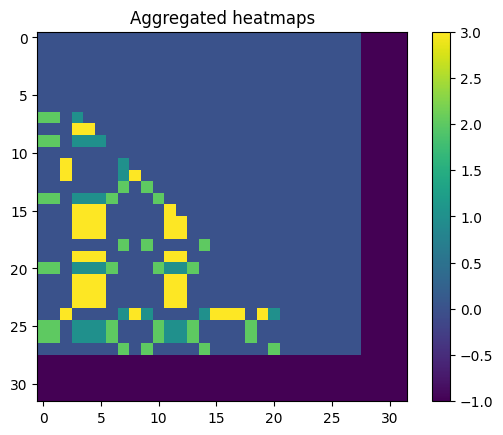

In [7]:
visualize.heatmap(train_x[3])

### Reinforcement Learning

